# Concrete Strength Prediction - Model Development

This notebook implements and compares different machine learning models for predicting concrete compressive strength:

1. Linear Regression with PCA (first 6 components)
2. Random Forest with original features
3. Decision Tree with original features
4. Neural Network with original features

For each model we will:
- Train the model
- Evaluate performance using R² and RMSE
- Create scatter plots comparing predicted vs actual values
- Save the model for future use

Let's begin by importing libraries and setting up our environment.


In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import joblib
import os

# Set style for better visualizations
plt.style.use('default')
sns.set_palette("husl")

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Create models directory if it doesn't exist
os.makedirs('../models', exist_ok=True)

print("Libraries imported and environment set up successfully!")


Libraries imported and environment set up successfully!


In [2]:
# Define helper functions for visualization and evaluation
def create_prediction_plot(y_true, y_pred, title, ax):
    """
    Create a scatter plot of predicted vs actual values with additional information.
    
    Parameters:
    -----------
    y_true : array-like
        True target values
    y_pred : array-like
        Predicted target values
    title : str
        Plot title
    ax : matplotlib axis
        Axis to plot on
    """
    # Calculate metrics
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    # Create scatter plot
    ax.scatter(y_true, y_pred, alpha=0.5, color='blue', label='Predictions')
    
    # Add perfect prediction line
    line_min = min(min(y_true), min(y_pred))
    line_max = max(max(y_true), max(y_pred))
    ax.plot([line_min, line_max], [line_min, line_max], 
            'r--', label='Perfect Prediction', alpha=0.8)
    
    # Add regression line
    z = np.polyfit(y_true, y_pred, 1)
    p = np.poly1d(z)
    ax.plot(y_true, p(y_true), 'g-', 
            label=f'Regression Line (slope={z[0]:.2f})', alpha=0.8)
    
    # Customize plot
    ax.set_xlabel('Actual Strength (MPa)')
    ax.set_ylabel('Predicted Strength (MPa)')
    ax.set_title(f'{title}\nR² = {r2:.4f}, RMSE = {rmse:.2f}')
    ax.legend(loc='upper left', fontsize=8)
    ax.grid(True, alpha=0.3)
    
    # Add text box with metrics
    stats_text = f'Statistics:\n' \
                 f'R² Score: {r2:.4f}\n' \
                 f'RMSE: {rmse:.2f}\n' \
                 f'Min Error: {min(y_true - y_pred):.2f}\n' \
                 f'Max Error: {max(y_true - y_pred):.2f}'
    ax.text(0.95, 0.05, stats_text,
            transform=ax.transAxes,
            verticalalignment='bottom',
            horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
            fontsize=8)

def evaluate_model(y_true, y_pred, model_name):
    """
    Calculate and print model performance metrics.
    """
    print(f"\n{model_name} Performance:")
    print("-" * 50)
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    print(f"R² Score: {r2:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"Min Error: {min(y_true - y_pred):.4f}")
    print(f"Max Error: {max(y_true - y_pred):.4f}")
    
    return r2, rmse

print("Helper functions defined successfully!")


Helper functions defined successfully!


In [3]:
# Load and prepare datasets
print("Loading datasets...")

# Load both PCA and non-PCA datasets
df_pca = pd.read_csv('../data/processed/concrete_data_pca.csv')
df_no_pca = pd.read_csv('../data/processed/concrete_data_scaled_no_pca.csv')

# Display initial information
print("\nInitial dataset shapes:")
print(f"PCA dataset: {df_pca.shape}")
print(f"Non-PCA dataset: {df_no_pca.shape}")

# Check for missing values
print("\nMissing values in PCA dataset:")
print(df_pca.isnull().sum())
print("\nMissing values in non-PCA dataset:")
print(df_no_pca.isnull().sum())

# Keep only first 6 principal components for PCA dataset
pca_features = [f'PC{i}' for i in range(1, 7)]
target_col = 'csMPa'

# Prepare PCA dataset (for Linear Regression only)
df_pca_subset = df_pca[pca_features + [target_col]].dropna()
X_pca = df_pca_subset[pca_features]
y_pca = df_pca_subset[target_col]

# Prepare non-PCA dataset (for all other models)
X_no_pca = df_no_pca.drop(columns=[target_col])
y_no_pca = df_no_pca[target_col]

# Create train-test splits
X_pca_train, X_pca_test, y_pca_train, y_pca_test = train_test_split(
    X_pca, y_pca, test_size=0.2, random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(
    X_no_pca, y_no_pca, test_size=0.2, random_state=42
)

# Print final dataset information
print("\nFinal dataset splits:")
print(f"PCA Training set: {X_pca_train.shape}")
print(f"PCA Test set: {X_pca_test.shape}")
print(f"Original Training set: {X_train.shape}")
print(f"Original Test set: {X_test.shape}")

# Verify no missing values
print("\nVerifying no missing values:")
print("PCA features:", X_pca.isnull().sum().sum())
print("PCA target:", y_pca.isnull().sum())
print("Original features:", X_no_pca.isnull().sum().sum())
print("Original target:", y_no_pca.isnull().sum())


Loading datasets...

Initial dataset shapes:
PCA dataset: (1005, 9)
Non-PCA dataset: (1005, 9)

Missing values in PCA dataset:
PC1       0
PC2       0
PC3       0
PC4       0
PC5       0
PC6       0
PC7       0
PC8       0
csMPa    25
dtype: int64

Missing values in non-PCA dataset:
cement              0
slag                0
flyash              0
water               0
superplasticizer    0
coarseaggregate     0
fineaggregate       0
age                 0
csMPa               0
dtype: int64

Final dataset splits:
PCA Training set: (784, 6)
PCA Test set: (196, 6)
Original Training set: (804, 8)
Original Test set: (201, 8)

Verifying no missing values:
PCA features: 0
PCA target: 0
Original features: 0
Original target: 0



Training Linear Regression with PCA features...

Linear Regression with PCA Performance:
--------------------------------------------------
R² Score: 0.1349
RMSE: 15.7423
Min Error: -34.0690
Max Error: 51.2381

PCA Feature Coefficients:
  Feature  Coefficient
2     PC3     3.935433
5     PC6     1.128958
3     PC4     0.002803
1     PC2    -0.348596
0     PC1    -1.265355
4     PC5    -2.158812

Training Random Forest with original features...

Random Forest Performance:
--------------------------------------------------
R² Score: 0.9073
RMSE: 5.2575
Min Error: -10.6300
Max Error: 35.6484

Feature Importances:
            Feature  Importance
7               age    0.361133
0            cement    0.302469
4  superplasticizer    0.089091
3             water    0.084540
1              slag    0.072161
6     fineaggregate    0.046864
5   coarseaggregate    0.026911
2            flyash    0.016833

Training Decision Tree with original features...

Decision Tree Performance:
---------------

c:\Users\alire\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 1417.8861 - val_loss: 1427.8828
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1293.5360 - val_loss: 1206.6184
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1037.2527 - val_loss: 787.0914
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 599.9854 - val_loss: 335.2108
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 281.6068 - val_loss: 203.0376
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 230.1458 - val_loss: 193.5847
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 230.6187 - val_loss: 184.4557
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 221.0068 - val_loss: 176.4838
Epoch 9/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 198.8868 - val_loss: 172.4765
Epoch 10/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 196.4214 - val_loss: 168.7585
Epoch 11/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 203.4342 - val_loss: 164.6399
Epo

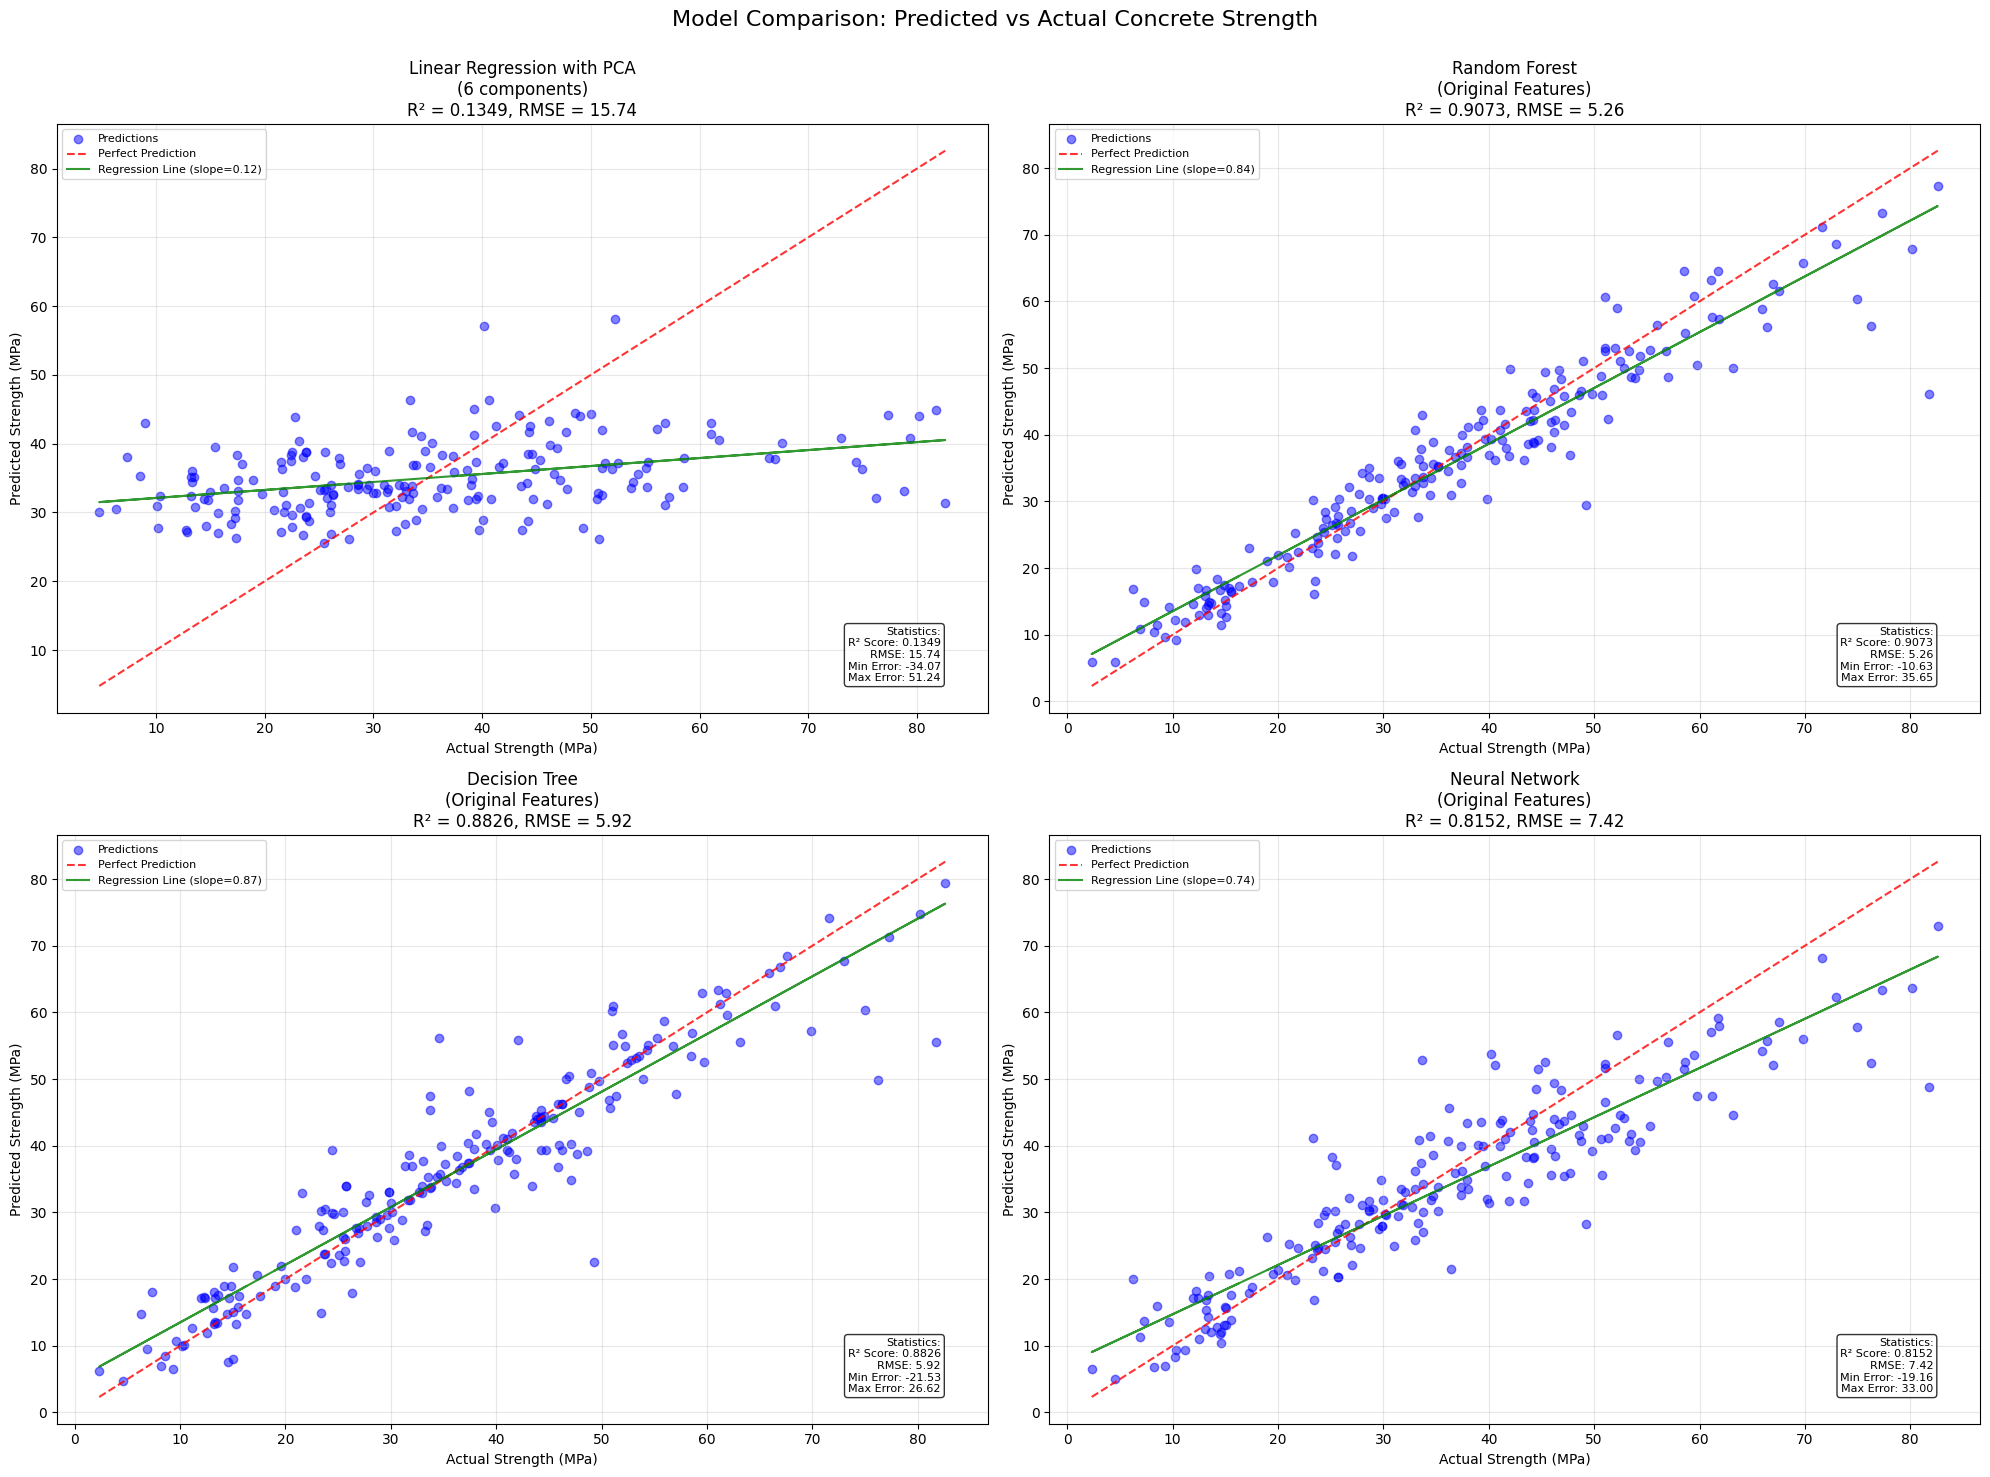

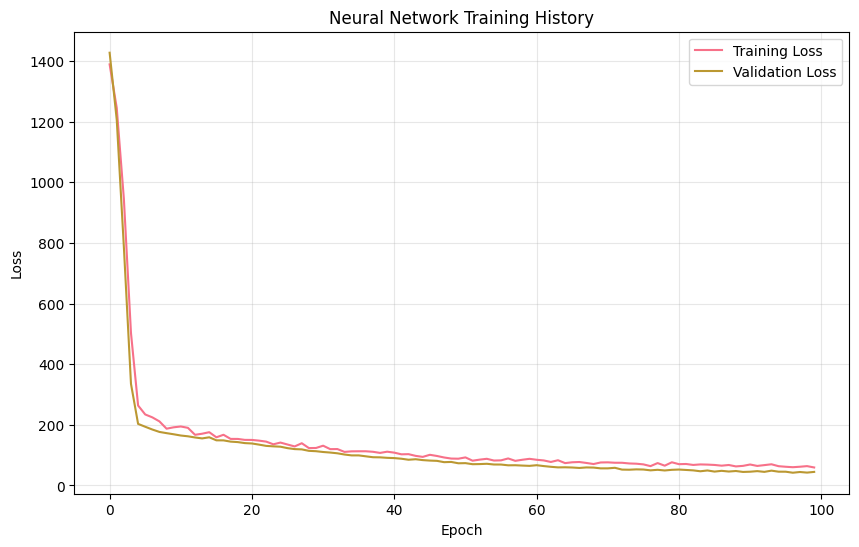

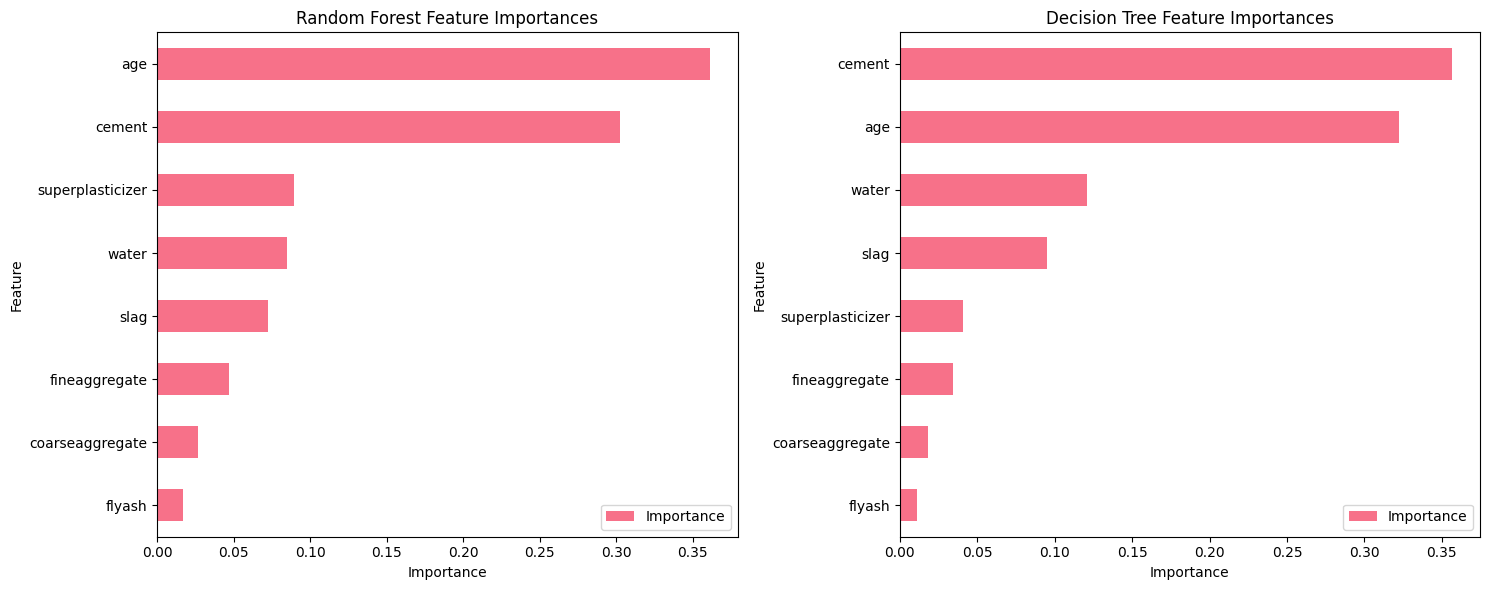

In [4]:
# Set up the main figure for all model comparisons
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
fig.suptitle('Model Comparison: Predicted vs Actual Concrete Strength', fontsize=16, y=0.95)
axes = axes.ravel()

# 1. Linear Regression with PCA features
print("\nTraining Linear Regression with PCA features...")
lr_pca = LinearRegression()
lr_pca.fit(X_pca_train, y_pca_train)
y_pred_lr_pca = lr_pca.predict(X_pca_test)

# Evaluate and visualize
r2_lr_pca, rmse_lr_pca = evaluate_model(y_pca_test, y_pred_lr_pca, "Linear Regression with PCA")
create_prediction_plot(y_pca_test, y_pred_lr_pca, 'Linear Regression with PCA\n(6 components)', axes[0])

# Print feature coefficients
print("\nPCA Feature Coefficients:")
coef_df = pd.DataFrame({
    'Feature': pca_features,
    'Coefficient': lr_pca.coef_
})
print(coef_df.sort_values('Coefficient', ascending=False))

# Save model
joblib.dump(lr_pca, '../models/linear_regression_pca.joblib')

# 2. Random Forest with original features
print("\nTraining Random Forest with original features...")
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Evaluate and visualize
r2_rf, rmse_rf = evaluate_model(y_test, y_pred_rf, "Random Forest")
create_prediction_plot(y_test, y_pred_rf, 'Random Forest\n(Original Features)', axes[1])

# Print feature importances
print("\nFeature Importances:")
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf.feature_importances_
})
print(importance_df.sort_values('Importance', ascending=False))

# Save model
joblib.dump(rf, '../models/random_forest.joblib')

# 3. Decision Tree with original features
print("\nTraining Decision Tree with original features...")
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

# Evaluate and visualize
r2_dt, rmse_dt = evaluate_model(y_test, y_pred_dt, "Decision Tree")
create_prediction_plot(y_test, y_pred_dt, 'Decision Tree\n(Original Features)', axes[2])

# Print feature importances
print("\nFeature Importances:")
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': dt.feature_importances_
})
print(importance_df.sort_values('Importance', ascending=False))

# Save model
joblib.dump(dt, '../models/decision_tree.joblib')

# 4. Neural Network with original features
print("\nTraining Neural Network with original features...")

# Define model architecture
model = Sequential([
    Dense(64, activation='relu', input_dim=X_train.shape[1]),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.1),
    Dense(16, activation='relu'),
    Dense(1)
])

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

# Make predictions
y_pred_nn = model.predict(X_test)

# Evaluate and visualize
r2_nn, rmse_nn = evaluate_model(y_test, y_pred_nn.flatten(), "Neural Network")
create_prediction_plot(y_test, y_pred_nn.flatten(), 'Neural Network\n(Original Features)', axes[3])

# Save model
model.save('../models/neural_network.keras')

# Adjust subplot layout and display
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Plot Neural Network training history in a separate figure
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Neural Network Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Plot feature importances for tree-based models
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Random Forest feature importances
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=True)
importance_df.plot(kind='barh', x='Feature', y='Importance', ax=ax1)
ax1.set_title('Random Forest Feature Importances')
ax1.set_xlabel('Importance')

# Decision Tree feature importances
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': dt.feature_importances_
}).sort_values('Importance', ascending=True)
importance_df.plot(kind='barh', x='Feature', y='Importance', ax=ax2)
ax2.set_title('Decision Tree Feature Importances')
ax2.set_xlabel('Importance')

plt.tight_layout()
plt.show()



Model Performance Comparison:
                               R²       RMSE
Random Forest            0.907344   5.257518
Decision Tree            0.882564   5.918962
Neural Network           0.815241   7.424171
Linear Regression (PCA)  0.134949  15.742299


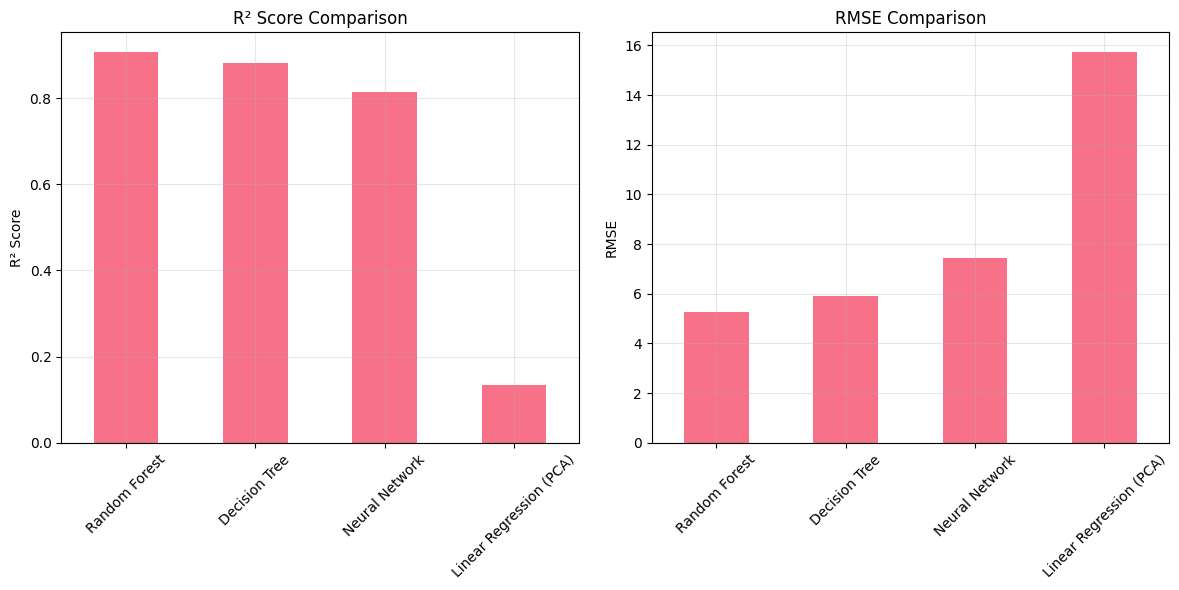


Conclusions:
1. Best performing model: Random Forest
   - R² Score: 0.9073
   - RMSE: 5.2575

2. Second best model: Decision Tree
   - R² Score: 0.8826
   - RMSE: 5.9190


In [5]:
# Compare all models
models_results = {
    'Linear Regression (PCA)': {'R²': r2_lr_pca, 'RMSE': rmse_lr_pca},
    'Random Forest': {'R²': r2_rf, 'RMSE': rmse_rf},
    'Decision Tree': {'R²': r2_dt, 'RMSE': rmse_dt},
    'Neural Network': {'R²': r2_nn, 'RMSE': rmse_nn}
}

# Create summary DataFrame
results_df = pd.DataFrame.from_dict(models_results, orient='index')
results_df = results_df.sort_values('R²', ascending=False)

print("\nModel Performance Comparison:")
print("=" * 80)
print(results_df)

# Create comparison plots
plt.figure(figsize=(12, 6))

# R² Score comparison
plt.subplot(1, 2, 1)
results_df['R²'].plot(kind='bar')
plt.title('R² Score Comparison')
plt.ylabel('R² Score')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# RMSE comparison
plt.subplot(1, 2, 2)
results_df['RMSE'].plot(kind='bar')
plt.title('RMSE Comparison')
plt.ylabel('RMSE')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print conclusions
print("\nConclusions:")
print("=" * 80)
print(f"1. Best performing model: {results_df.index[0]}")
print(f"   - R² Score: {results_df.iloc[0]['R²']:.4f}")
print(f"   - RMSE: {results_df.iloc[0]['RMSE']:.4f}")
print(f"\n2. Second best model: {results_df.index[1]}")
print(f"   - R² Score: {results_df.iloc[1]['R²']:.4f}")
print(f"   - RMSE: {results_df.iloc[1]['RMSE']:.4f}")

# Save results
results_df.to_csv('../models/model_comparison_results.csv')
